In [1]:
# Handle different types of transformation
# different nb of pixels
# different nb of level of gray

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
# from sklearn import tree
import os
import random

mpl.rc('image', cmap='gray_r')
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import load_model

C:\Users\MariO\Anaconda3\envs\PythonData\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Useful methods

In [3]:
def rot90ccw(mat):
    """ Rotate an n by n matrix 90 deg counter clock wise"""
    
    # rotation matrix
    rot = np.array([[0, 1],
               [-1,0]])
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][0] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

def rot90cw(mat):
    """ Rotate an n by n matrix 90 deg clock wise"""
    
    # rotation matrix
    rot = np.array([[0, -1],
               [1,0]])    
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][1] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

In [4]:
# Transformation matrices
def create_PPstar_translation(nbpix):
    # nb of pixels translated
    nbt = int(np.round(0.25*nbpix))

    # bottom left square block
    bl = np.eye(nbpix-nbt,nbpix-nbt)
    # upper right square block
    ur = np.eye(nbt,nbt)
    # upper left rect block
    ul = np.zeros((nbt,nbpix-nbt))
    # bottom right rect block
    br = np.zeros((nbpix-nbt,nbt))

    # concatenate the blocks to build the transformation matrix
    P = np.concatenate((np.concatenate((ul,ur), axis=1), np.concatenate((bl,br), axis=1)), axis=0)
    Pstar = np.linalg.inv(P)        
    return (P,Pstar)

def translate2left(mat):
    P,Pstar = create_PPstar_translation(mat.shape[0])
    return mat@P
def translate2right(mat):
    P,Pstar = create_PPstar_translation(mat.shape[0])
    return mat@Pstar


In [5]:
# plt.figure(1)
def remove_ticks():
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off    
    return

def vis_matrices(Mr, Mm, Mst, MstM):
#     print(Mr.shape[0])
    if Mr.shape[0]==1:
        Mr = Mr.reshape(int(np.sqrt(Mr.shape[1])), int(np.sqrt(Mr.shape[1])))
        Mm = Mm.reshape(int(np.sqrt(Mm.shape[1])), int(np.sqrt(Mm.shape[1])))
        Mst = Mst.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))
        MstM = MstM.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))

    
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=2) #, squeeze=True, sharey=True)
    fig.set_size_inches(8,8)

    plt.sca(ax1[0])
    plt.imshow(Mr)
    plt.title("Real image")
    remove_ticks()

    plt.sca(ax2[0])
    plt.imshow(Mm)
    plt.title("Distorted image")
    remove_ticks()

    plt.sca(ax1[1])
    plt.imshow(Mst)
    plt.title("Corrected input")
    remove_ticks()

    plt.sca(ax2[1])
    plt.imshow(MstM)
    plt.title("Corrected visualization")
    remove_ticks()

In [6]:
def create_training_data(nbpix,transform_type):
    """
    Build the set of one pixel matrices and apply the transformations
    """
    # List of indexes where to put a black pixel
    idx = range(0,nbpix**2,1)

    # Initialize empty arrays 
    Mreal_tab = np.zeros((len(idx),nbpix*nbpix))
    Mmang_tab = np.zeros((len(idx),nbpix*nbpix))
    Mstar_tab = np.zeros((len(idx),nbpix*nbpix))
    for ii in idx:
        # Fill the indexed pixel with a one
        Mreal_tab[ii,ii] = 1
        # Use the transformation matrices to generate Mmang and Mstar
#         Mmang_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@P).reshape(1,nbpix**2)
#         Mstar_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@Pstar).reshape(1,nbpix**2)
            
        if transform_type is "translation":    
            Mmang_tab[ii,:] = translate2left(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            Mstar_tab[ii,:] = translate2right(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
        elif transform_type is "rotation":
            Mmang_tab[ii,:] = rot90ccw(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            Mstar_tab[ii,:] = rot90cw(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            
    return (Mreal_tab, Mmang_tab, Mstar_tab)

In [7]:
# Function to add one on the designated index
def add_one(arr,index):
    arr[0,index] = 1
    return arr

# Function to split the matrix into matrices of one pixel
def split_matrix(mat):
    """ Split a matrix into matrices of one pixel"""
    # find the indexes of the ones values in the matrix
#     idx_arr = np.where(mat.reshape(1,nbpix**2)[0]==1)[0]
    idx_arr = np.where(mat.reshape(1,nbpix**2)[0]>0)[0]
    # transform from an array to a list
    idx_lst = [idx_arr.item(ii) for ii in range(0,len(idx_arr))] 
    temp = np.zeros((1,nbpix**2))
    mat_split = np.zeros((len(idx_lst), nbpix**2))
#     Mtest = np.zeros((nbpix,nbpix))
    for ii in range(0,len(idx_lst)):
        mat_split[ii,idx_lst[ii]] = 1    
#         Mtest = Mtest + Mreal_split[ii,:].reshape(nbpix,nbpix)
    return mat_split

In [8]:
# Prediction functions
def perform_prediction(mat, model):
    """ Predict the output with a trained model"""
    # split the input matrix into matrices of one pixel
    mat_split = split_matrix(mat)
    nb_dark_pxl = mat_split.shape[0]
    
    # initializations
    res = np.zeros((nb_dark_pxl, nbpix**2))
    Mres = np.zeros((nbpix,nbpix))
    # Loop on all the one pixels array
    for ii in range(0,nb_dark_pxl):
        # Apply the models to the one pixel matrices
#         print(mat_split[ii])
        res[ii,:] = model.predict(np.expand_dims(mat_split[ii], axis=0))
        # Sum up the results to construct the matrices
        Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
    return Mres

# def predict_corrector(mat):
#     # split the input matrix into matrices of one pixel
#     mat_split = split_matrix(mat)
#     nb_dark_pxl = mat_split.shape[0]
    
#     # initializations
#     res = np.zeros((nb_dark_pxl, nbpix**2))
#     Mres = np.zeros((nbpix,nbpix))
#     # Loop on all the one pixels array
#     for ii in range(0,nb_dark_pxl):
#         # Apply the models to the one pixel matrices
#         res[ii,:] = model_corrector.predict(np.expand_dims(mat_split[ii], axis=0))
#         # Sum up the results to construct the matrices
#         Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
#     return Mres

In [9]:
def create_door_img(nbpix):
    """ Create an nbpix by nbpix image of a door"""
    nbborder = int(np.round(nbpix*0.3))
    u = np.ones((nbborder,nbpix))
    l = np.ones((nbpix-nbborder,nbborder))
    r = l
    door = np.zeros((nbpix-nbborder, nbpix-2*nbborder))

    return np.concatenate((u,np.concatenate((l,door,r), axis=1)), axis=0)

In [10]:


# def grayscale_cmap(cmap):
#     """Return a grayscale version of the given colormap"""
#     cmap = plt.cm.get_cmap(cmap)
#     colors = cmap(np.arange(cmap.N))
    
#     # convert RGBA to perceived grayscale luminance
#     # cf. http://alienryderflex.com/hsp.html
#     RGB_weight = [0.299, 0.587, 0.114]
#     luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
#     colors[:, :3] = luminance[:, np.newaxis]
        
#     return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)

# mpl.rc('image', cmap=grayscale_cmap("viridis_r"))
   

 ## MAIN

In [44]:
# Parameters
nbpix = 4 # nb of pixel to consider (nbpix x nbpix)
transform_type = "translation" # type of transformation : "translation" or "rotation"
training_type = "full" # type of training: "partial" of "full"

In [12]:
# create the transformation matrices

# import random
# (P,Pstar) = create_PPstar(nbpix)

# Create the training data
(Mreal_tab, Mmang_tab, Mstar_tab) = create_training_data(nbpix,transform_type)


# the training input are the matrices of the real images with one pixel

if training_type == "partial": # we remove randomly 20% of the training data
    # rebuild the list of indexes and shuffle it
    rdm_idx = list(range(0,nbpix**2,1))
    random.shuffle(rdm_idx)
    
    # remove 80% of the indexes of this list
    rdm_idx[0:int(np.round(nbpix**2*0.8))] = []
    
    # delete the corresponding rows in the training matrices
    Mreal_tab = np.delete(Mreal_tab, rdm_idx, axis=0)
    Mmang_tab = np.delete(Mmang_tab, rdm_idx, axis=0)
    Mstar_tab = np.delete(Mstar_tab, rdm_idx, axis=0)
    
    print(f"Training performed on {Mreal_tab.shape[0]}/{Mreal_tab.shape[1]} pixels")

idx = range(0,Mreal_tab.shape[0],1)        
X_train = Mreal_tab   


In [32]:
# the training output will be the category corresponding to the position of the pixel in the mangled image
y_train = [np.where(Mmang_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train = to_categorical(y_train, nbpix**2)

# or the position of the pixel in the corrected image
y_train_cor = [np.where(Mstar_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train_cor = to_categorical(y_train_cor, nbpix**2)

# creating the models
model_mangler = Sequential()
model_mangler.add(Dense(10*nbpix**2, activation='relu', input_dim=nbpix**2))
model_mangler.add(Dense(10*nbpix**2, activation='relu'))
model_mangler.add(Dense(nbpix**2, activation='softmax'))
# Inversion strategy doesnt work very well...
# we are going to try using another model, trained on the corrected input.
model_corrector = Sequential()
model_corrector.add(Dense(10*nbpix**2, activation='relu', input_dim=nbpix**2))
model_corrector.add(Dense(10*nbpix**2, activation='relu'))
model_corrector.add(Dense(nbpix**2, activation='softmax'))

# Compile the models
model_mangler.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model_corrector.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

# train the model "mangler"
model_mangler.fit( X_train,
    y_train,
    epochs=10*nbpix**2,
    shuffle=True,
    verbose=1
)

# train the corrected input model
model_corrector.fit( X_train,
    y_train_cor,
    epochs=10*nbpix**2,
    shuffle=True,
    verbose=1
)    

# model_mangler.summary()
# model_corrector.summary()

# Save the models
model_mangler.save(f"{transform_type}_{training_type}_mangler_{nbpix}x{nbpix}.h5")
model_corrector.save(f"{transform_type}_{training_type}_corrector_{nbpix}x{nbpix}.h5")

Epoch 1/160
16/16 [==============================] - 0s 28ms/step - loss: 2.7709 - acc: 0.1250
Epoch 2/160
16/16 [==============================] - 0s 188us/step - loss: 2.7369 - acc: 0.1250
Epoch 3/160
16/16 [==============================] - 0s 125us/step - loss: 2.7042 - acc: 0.1875
Epoch 4/160
16/16 [==============================] - 0s 188us/step - loss: 2.6732 - acc: 0.3125
Epoch 5/160
16/16 [==============================] - 0s 125us/step - loss: 2.6427 - acc: 0.5000
Epoch 6/160
16/16 [==============================] - 0s 250us/step - loss: 2.6128 - acc: 0.7500
Epoch 7/160
16/16 [==============================] - 0s 500us/step - loss: 2.5833 - acc: 0.9375
Epoch 8/160
16/16 [==============================] - 0s 250us/step - loss: 2.5539 - acc: 0.9375
Epoch 9/160
16/16 [==============================] - 0s 375us/step - loss: 2.5245 - acc: 0.9375
Epoch 10/160
16/16 [==============================] - 0s 250us/step - loss: 2.4948 - acc: 0.9375
Epoch 11/160
16/16 [====================

Epoch 86/160
16/16 [==============================] - 0s 250us/step - loss: 0.0337 - acc: 1.0000
Epoch 87/160
16/16 [==============================] - 0s 125us/step - loss: 0.0321 - acc: 1.0000
Epoch 88/160
16/16 [==============================] - 0s 188us/step - loss: 0.0307 - acc: 1.0000
Epoch 89/160
16/16 [==============================] - 0s 125us/step - loss: 0.0295 - acc: 1.0000
Epoch 90/160
16/16 [==============================] - 0s 188us/step - loss: 0.0283 - acc: 1.0000
Epoch 91/160
16/16 [==============================] - 0s 375us/step - loss: 0.0271 - acc: 1.0000
Epoch 92/160
16/16 [==============================] - 0s 125us/step - loss: 0.0261 - acc: 1.0000
Epoch 93/160
16/16 [==============================] - 0s 188us/step - loss: 0.0252 - acc: 1.0000
Epoch 94/160
16/16 [==============================] - 0s 125us/step - loss: 0.0243 - acc: 1.0000
Epoch 95/160
16/16 [==============================] - 0s 188us/step - loss: 0.0235 - acc: 1.0000
Epoch 96/160
16/16 [==========

Epoch 10/160
16/16 [==============================] - 0s 250us/step - loss: 2.5205 - acc: 0.8125
Epoch 11/160
16/16 [==============================] - 0s 125us/step - loss: 2.4914 - acc: 0.8750
Epoch 12/160
16/16 [==============================] - 0s 188us/step - loss: 2.4616 - acc: 0.9375
Epoch 13/160
16/16 [==============================] - 0s 188us/step - loss: 2.4311 - acc: 1.0000
Epoch 14/160
16/16 [==============================] - 0s 125us/step - loss: 2.3999 - acc: 1.0000
Epoch 15/160
16/16 [==============================] - 0s 125us/step - loss: 2.3678 - acc: 1.0000
Epoch 16/160
16/16 [==============================] - 0s 125us/step - loss: 2.3346 - acc: 1.0000
Epoch 17/160
16/16 [==============================] - 0s 125us/step - loss: 2.3004 - acc: 1.0000
Epoch 18/160
16/16 [==============================] - 0s 188us/step - loss: 2.2651 - acc: 1.0000
Epoch 19/160
16/16 [==============================] - 0s 188us/step - loss: 2.2287 - acc: 1.0000
Epoch 20/160
16/16 [==========

Epoch 95/160
16/16 [==============================] - 0s 188us/step - loss: 0.0246 - acc: 1.0000
Epoch 96/160
16/16 [==============================] - 0s 188us/step - loss: 0.0238 - acc: 1.0000
Epoch 97/160
16/16 [==============================] - 0s 250us/step - loss: 0.0230 - acc: 1.0000
Epoch 98/160
16/16 [==============================] - 0s 250us/step - loss: 0.0223 - acc: 1.0000
Epoch 99/160
16/16 [==============================] - 0s 125us/step - loss: 0.0216 - acc: 1.0000
Epoch 100/160
16/16 [==============================] - 0s 188us/step - loss: 0.0210 - acc: 1.0000
Epoch 101/160
16/16 [==============================] - 0s 188us/step - loss: 0.0204 - acc: 1.0000
Epoch 102/160
16/16 [==============================] - 0s 250us/step - loss: 0.0198 - acc: 1.0000
Epoch 103/160
16/16 [==============================] - 0s 250us/step - loss: 0.0193 - acc: 1.0000
Epoch 104/160
16/16 [==============================] - 0s 188us/step - loss: 0.0188 - acc: 1.0000
Epoch 105/160
16/16 [====

In [45]:
# Apply the models to an existing image

# Load the saved models
model_mangler = load_model(f"{transform_type}_{training_type}_mangler_{nbpix}x{nbpix}.h5")
model_corrector = load_model(f"{transform_type}_{training_type}_corrector_{nbpix}x{nbpix}.h5")

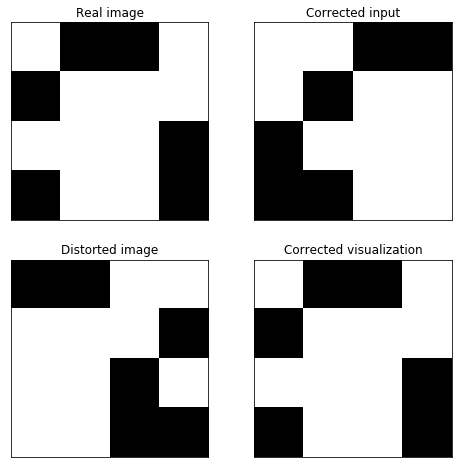

In [46]:
# Mreal = create_door_img(nbpix) 
cut = 0.5
Mreal = np.random.choice([0, 1], size=(nbpix,nbpix), p=[ 1-cut, cut])
# Mreal_split = split_matrix(Mreal)

# Predict the mangled image based on the real one
Mmang_ml = perform_prediction(Mreal,model_mangler ) # predict_mangler(Mreal)
# Predict the corrected input based on the real image
Mcor_ml = perform_prediction(Mreal, model_corrector)# predict_corrector(Mreal)
# Prediction of the output from the corrected input
Mout_ml = perform_prediction(np.round(Mcor_ml), model_mangler)
# plot the results
# vis_matrices(Mreal, Mmang_ml,Mcor_ml, Mout_ml)
if transform_type == "translation":
    vis_matrices(Mreal, Mmang_ml,Mcor_ml, translate2left(Mcor_ml))
elif transform_type == "rotation":
    print(Mcor_ml)
    vis_matrices(Mreal, Mmang_ml,Mcor_ml, rot90ccw(Mcor_ml))
    
# print(transform_type)


In [47]:
def arrayToList(arr):
    return [ii.item() for ii in arr.reshape((arr.size,1))]

In [52]:
mang_matrices = {}
mang_matrices["Mcor"] = arrayToList(Mreal)

if transform_type == "translation":
    mang_matrices["Mout"] = translate2right(np.asarray(mang_matrices["Mcor"]).reshape(nbpix,nbpix))
elif transform_type == "rotation":
    mang_matrices["Mout"] = rot90cw(np.asarray(mang_matrices["Mcor"]).reshape(nbpix,nbpix))

# mang_matrices = {"Mout": arrayToList(Mmang_ml)}
print(mang_matrices)

{'Mcor': [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1], 'Mout': array([[0., 0., 1., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 1., 0., 0.]])}


In [21]:
# transform into a list
mat_list = [ii.item() for ii in Mreal.reshape((nbpix**2,1))]

In [22]:

# Mreal.size

[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]

In [23]:
np.arange(4,16,2)

array([ 4,  6,  8, 10, 12, 14])

In [24]:
arrayToList(np.arange(4,16,2))

[4, 6, 8, 10, 12, 14]

In [25]:
# decoding the matrix from the route url
import re
nbpixTransformMat = "4rotation1101110100010001"
nbpix = int(re.search(r'\d+', nbpixTransformMat).group())
print(nbpix)
transform_type = ''.join([i for i in nbpixTransformMat if not i.isdigit()])   
print(transform_type)
training_type = "full" # for now we only use fully trained models

mat = nbpixTransformMat[-nbpix**2:]

input_values = np.asarray([int(mm) for mm in nbpixTransformMat[-nbpix**2:]])
input_values

4
rotation


array([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [26]:
# The output from the corrected input

def arrayToList(arr):
    """ Transform a np.array of any size into a flat list """
    return [ii.item() for ii in arr.reshape((arr.size,1))]
def translate2right2(mat, nbpix):
    P,Pstar = create_PPstar_translation(nbpix)
    mat = np.asarray(mat).reshape(nbpix,nbpix)

    return mat@Pstar   

def rot90cw2(mat, nbpix):
    """ Rotate an n by n matrix 90 deg counter clock wise"""

    mat = np.asarray(mat).reshape(nbpix,nbpix)
    print(mat)
    print(mat.shape)
    
    # rotation matrix
    rot = np.array([[0, -1],
               [1,0]])
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    print(len(coord))
    for ii in range(0,len(coord)):
        print(ii)
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][0] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

[[1 1 0 1]
 [1 1 0 1]
 [0 0 0 1]
 [0 0 0 1]]
(4, 4)
16
0
1


IndexError: index 4 is out of bounds for axis 0 with size 4